In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa
from datetime import datetime
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from pesq import pesq
import pystoi
import pandas as pd

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance, calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from data_generators import NoisyTargetWithMetricsGenerator
from sound import Sound
import tensorflow.keras.backend as K

In [13]:
from artigos.PRIDNet import Convolutional_block, Channel_attention, AttResUnetConvLSTM, Avg_pool_Unet_Upsample_msfe, Multi_scale_feature_extraction, Kernel_selecting_module
from keras.utils import custom_object_scope

In [3]:
base_shape_size = 8192
ws = 255
ol = 128

In [4]:
sound_base = Sound('../../../Dados/Vozes/', '../../../Dados/Ruido/', base_shape_size)

Loading Noise Files: 100%|██████████| 8137/8137 [00:07<00:00, 1127.62it/s]
/tf/utils/sound.py:65: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]


In [5]:
def stft_to_signal(stft, sampling_rate=8000, window_size=ws, overlap=ol):
    A = stft[..., 0]
    phi = stft[..., 1]
    signal = reconstruct_signal_from_stft(A, phi, sampling_rate=sampling_rate, window_size=window_size, overlap=overlap)

    return signal

In [6]:
data_generator = NoisyTargetWithMetricsGenerator(sound_base.train_X, sound_base.noise_sounds)

In [7]:
def process_batch(x_batch, y_batch, model):
    stfts = model.predict(x_batch, verbose=False)
    M, height, width, channels = stfts.shape  # Obtenha as dimensões do array de resultados do modelo

    pesq_scores = []
    stoi_scores = []
    snr_scores = []
    ID_scores = []

    for i in range(M):
        filtered = stfts[i, :, :, :]  # Obtenha o resultado do modelo para a iteração atual

        clean = y_batch[i, :, :, :]  # Obtenha o sinal limpo correspondente

        clean_signal = stft_to_signal(clean).reshape(-1)
        filtered_signal = stft_to_signal(filtered).reshape(-1)

        try:
            pesq_score = pesq(8000, clean_signal, filtered_signal, 'nb')
        except:
            pesq_score = 1.04
        stoi_score = pystoi.stoi(clean_signal, filtered_signal, 8000)
        snr_score = calculate_snr(clean_signal, filtered_signal)
        # ID_score = itakura_distortion(clean_signal, filtered_signal, 256, 11)

        pesq_scores.append(pesq_score)
        stoi_scores.append(stoi_score)
        snr_scores.append(snr_score)
        # ID_scores.append(ID_score)

    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [20]:
batch_num = 50
df_resultado = pd.DataFrame()

In [21]:
# model = load_model('DNS-loss-0.0212-epochs-3-2023-11-11_21-09-11.h5')
with custom_object_scope({'Convolutional_block': Convolutional_block,
                          'Channel_attention': Channel_attention,
                          'AttResUnetConvLSTM': AttResUnetConvLSTM,
                          'Avg_pool_Unet_Upsample_msfe': Avg_pool_Unet_Upsample_msfe,
                          'Multi_scale_feature_extraction': Multi_scale_feature_extraction,
                          'Kernel_selecting_module': Kernel_selecting_module}):
    model = load_model('PRIDNet_loss-0.0165-epochs-54.h5')

In [22]:
results = []

for _ in tqdm(range(batch_num)):
    x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_completo(batch_size=128))
    results.append((process_batch(x_batch, y_batch, model),metrics_batch_df))

df_resultado = pd.DataFrame()

for result , metrics_batch_df in results:
    pesq_scores, stoi_scores, snr_scores, ID_scores = result
    metrics_batch_df['PESQ (Filtered)'] = pesq_scores
    metrics_batch_df['STOI (Filtered)'] = stoi_scores
    metrics_batch_df['SNR (Filtered)'] = snr_scores
    # metrics_batch_df['ID (Filtered)'] = ID_scores
    
    df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [05:52<00:00,  7.05s/it]


In [23]:
df_resultado

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
0,2.052708,0.777886,2.940979,3.429985,0.924739,19.425374
1,2.105372,0.829841,4.915143,3.828122,0.955811,18.043438
2,2.639465,0.976901,14.868217,4.043564,0.986748,20.971754
3,2.689993,0.967331,8.936746,4.378371,0.996385,21.821980
4,1.487634,0.624850,3.890798,2.502166,0.702162,13.281286
...,...,...,...,...,...,...
6383,3.672277,0.977212,15.797763,4.115326,0.992076,18.876692
6384,2.365080,0.951809,19.946210,3.653749,0.950252,16.622143
6385,2.412590,0.989001,21.952291,3.742210,0.986197,18.443998
6386,2.837785,0.993977,23.902030,4.344949,0.990957,16.729410


In [24]:
df_resultado.describe()

,PESQ,STOI,SNR,PESQ (Filtered),STOI (Filtered),SNR (Filtered)
count,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000,6388.000000
mean,2.123009,0.842233,9.282952,3.433139,0.905704,13.292820
std,0.556997,0.134290,5.722685,0.579075,0.097862,3.623405
min,1.029168,0.058212,-0.117971,1.040000,0.042987,3.201633
25%,1.693802,0.772588,3.983947,3.068623,0.879783,10.373027
50%,2.050203,0.879808,8.952229,3.541217,0.938297,13.038991
75%,2.479873,0.946422,14.138606,3.895195,0.969403,16.107548
max,4.406038,0.998658,29.075851,4.431778,0.997119,23.524141


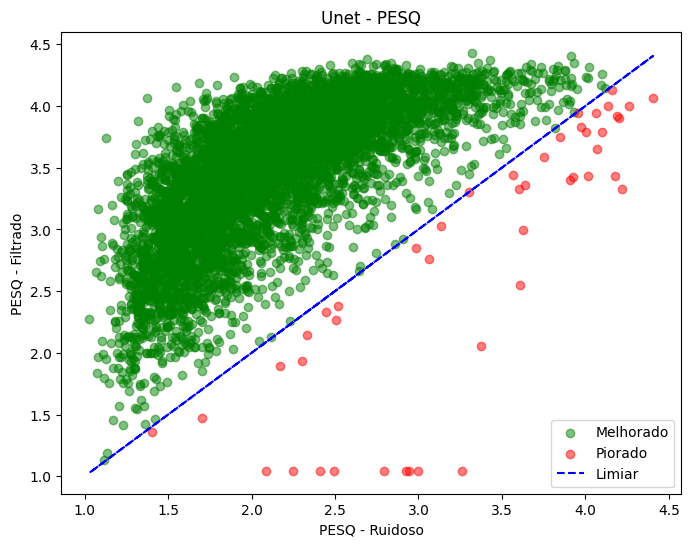

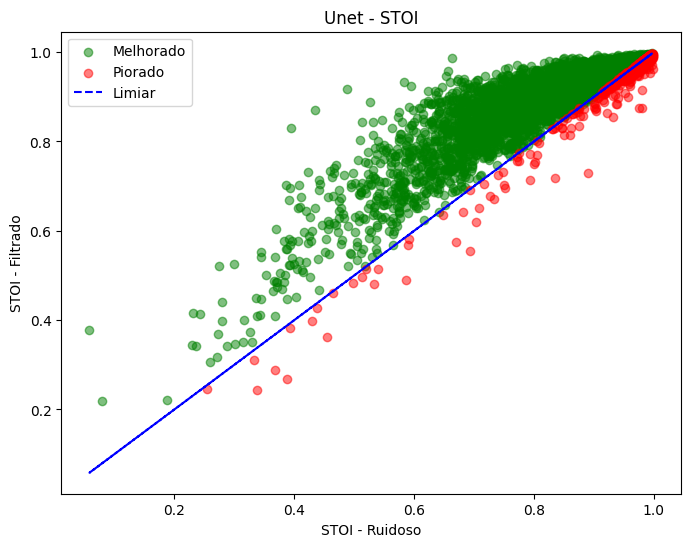

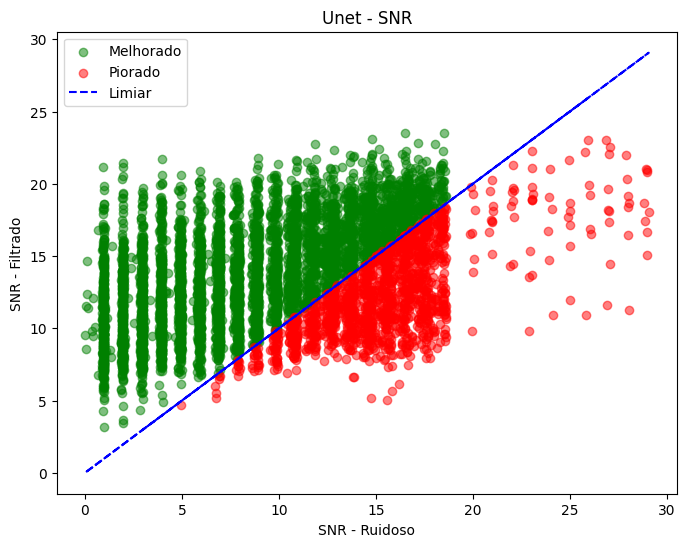

KeyError: 'ID'

<Figure size 800x600 with 0 Axes>

In [25]:
performance(df_resultado, 'Unet')

In [26]:
# Get the current datetime
current_datetime = datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Define the file name with the datetime
file_name = f"PRIDNet-metrics_{datetime_str}.xlsx"

In [27]:
df_resultado.to_excel(file_name, index=False)